In [1]:
!pip install GDAL

In [2]:
import os
import numpy as np
from osgeo import gdal
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
# Đặt seed để tái lập kết quả
torch.manual_seed(42)
np.random.seed(42)

# Định nghĩa các hằng số và đường dẫn
BASE_PATH = "/kaggle/input/btl-ai/DATA_SV"
HIMA_PATH = os.path.join(BASE_PATH, "Hima")
ERA5_PATH = os.path.join(BASE_PATH, "ERA5")
PRECIP_PATH = os.path.join(BASE_PATH, "Precipitation/Radar")
OUTPUT_PATH = "/kaggle/working/output/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [5]:
HIMA_BANDS = ['B04B', 'B05B', 'B06B', 'B09B', 'B10B', 'B11B', 'B12B', 'B14B', 'B16B', 'I2B', 'I4B', 'IRB', 'VSB', 'WVB']  # 14 band
ERA5_PARAMS = ['CAPE', 'CIN', 'EWSS', 'IE', 'ISOR', 'KX', 'PEV', 'R250', 'R500', 'R850', 'SLHF', 'SLOR', 'SSHF', 'TCLW', 'TCW', 'TCWV', 'U250', 'U850', 'V250', 'V850']  # 20 tham số
HEIGHT, WIDTH = 90, 250

# Chọn features để giữ lại
SELECTED_HIMA_BANDS = ['B09B', 'B10B', 'B11B', 'B12B', 'B14B', 'B16B', 'I2B', 'IRB', 'WVB', 'I4B']
SELECTED_ERA5_PARAMS = ['CAPE', 'CIN', 'EWSS', 'IE', 'ISOR', 'KX', 'PEV', 'R250', 'R500', 'R850', 'SLHF', 'SLOR', 'SSHF', 'TCLW', 'TCW', 'TCWV', 'U250', 'U850', 'V250', 'V850']

IN_CHANNEL = len(SELECTED_HIMA_BANDS) + len(SELECTED_ERA5_PARAMS)

In [6]:
# 2. Hàm xử lý dữ liệu
# Hàm đọc file GeoTIFF
import numpy as np

def read_geotiff(file_path, data_type="Radar", verbose=False):
    try:
        ds = gdal.Open(file_path)
        band = ds.GetRasterBand(1)
        nodata = band.GetNoDataValue()  # Lấy giá trị nodata
        data = band.ReadAsArray().astype(np.float32)
        ds = None
        
        # Kiểm tra kích thước
        HEIGHT, WIDTH = 90, 250  # Giả định HEIGHT và WIDTH đã được định nghĩa
        if data.shape != (HEIGHT, WIDTH):
            print(f"Invalid shape {data.shape} for file {file_path}, expected ({HEIGHT}, {WIDTH})")
            return None
        
        # Kiểm tra và xử lý giá trị nodata
        if nodata is not None:
            nodata_count = np.sum(data == nodata)
            # if verbose:
            #     print(f"Number of missing values in {file_path}: {nodata_count}")
            
            # Xử lý giá trị thiếu tùy theo loại dữ liệu
            if data_type == "Radar":
                data[data == nodata] = 0  # Điền bằng 0 cho lượng mưa
            elif data_type == "Hima":
                # Điền bằng giá trị trung bình
                mask = data != nodata
                if np.any(mask):
                    mean_value = np.mean(data[mask])
                    data[data == nodata] = mean_value
            elif data_type == "ERA5":
                # Điền bằng nội suy (giống như trước)
                mask = data == nodata
                if np.any(mask):
                    points = np.array([(i, j) for i in range(data.shape[0]) for j in range(data.shape[1]) if not mask[i, j]])
                    values = data[~mask]
                    xi = np.array([(i, j) for i in range(data.shape[0]) for j in range(data.shape[1]) if mask[i, j]])
                    interpolated_values = griddata(points, values, xi, method='nearest')
                    for idx, (i, j) in enumerate(xi):
                        data[xi[idx][0], xi[idx][1]] = interpolated_values[idx]
        
        return data
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None

In [7]:
# Hàm phân tích thời gian từ tên file
def parse_datetime_from_filename(filename, data_type):
    try:
        if data_type == "Hima":
            parts = filename.split('_')
            if len(parts) < 2:
                return None
            time_part = parts[1].split('_TB.tif')[0]
            time_part = time_part.replace('.Z', '')
            dt = datetime.strptime(time_part, '%Y%m%d%H%M')
        elif data_type == "ERA5":
            parts = filename.split('_')
            if len(parts) < 2:
                return None
            time_part = parts[1].replace('.tif', '')
            dt = datetime.strptime(time_part, '%Y%m%d%H%M%S')
        elif data_type == "Radar":
            time_part = filename.split('_')[1].replace('.tif', '')
            dt = datetime.strptime(time_part, '%Y%m%d%H%M%S')
        else:
            return None
        return dt.replace(minute=0, second=0, microsecond=0)
    except Exception as e:
        global error_count
        if error_count < 5:
            print(f"Error parsing datetime from {filename} (type {data_type}): {e}")
            error_count += 1
        return None

In [8]:
error_count = 0

# Hàm thu thập file
def collect_files(base_path, expected_subdirs=None, data_type=None):
    files_dict = {}
    file_count = 0
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.tif'):
                file_path = os.path.join(root, file)
                dt = parse_datetime_from_filename(file, data_type)
                if dt is None:
                    continue
                file_count += 1
                if expected_subdirs:
                    subdir = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(file_path)))))
                    if dt not in files_dict:
                        files_dict[dt] = {}
                    files_dict[dt][subdir] = file_path
                else:
                    files_dict[dt] = file_path
    print(f"Found {file_count} files in {base_path}")
    return files_dict

In [9]:
# Hàm xử lý dữ liệu thiếu và chuẩn hóa
def preprocess_data(data, data_type):
    if data is None:
        return None
    # Xử lý giá trị không hợp lệ
    data = np.where(np.isinf(data) | np.isnan(data) | (data == -9999), 0, data)
    if data_type == "Radar":
        # Log transformation cho radar
        data = np.log1p(np.maximum(data, 0))  # log(1 + x)
    else:
        # Min-max scaling cho Himawari và ERA5
        data_min, data_max = np.min(data), np.max(data)
        if data_max > data_min:
            data = (data - data_min) / (data_max - data_min)
        else:
            data = np.zeros_like(data)
    return data

In [10]:
# FocalLoss
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
    def forward(self, y_pred, y_true):
        mse_loss = nn.functional.mse_loss(y_pred, y_true, reduction='none')
        pt = torch.exp(-mse_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * mse_loss
        return focal_loss.mean()

In [11]:
import os
import numpy as np
from datetime import timedelta

def create_time_sequences(hima_files, era5_files, precip_files, common_datetimes, seq_len=3, max_gap_hours=3, batch_size=200):
    # Tính giá trị trung bình để điền dữ liệu thiếu
    hima_sums = {band: np.zeros((HEIGHT, WIDTH), dtype=np.float64) for band in SELECTED_HIMA_BANDS}
    era5_sums = {param: np.zeros((HEIGHT, WIDTH), dtype=np.float64) for param in SELECTED_ERA5_PARAMS}
    radar_sum = np.zeros((HEIGHT, WIDTH), dtype=np.float64)
    hima_counts = {band: 0 for band in SELECTED_HIMA_BANDS}
    era5_counts = {param: 0 for param in SELECTED_ERA5_PARAMS}
    radar_count = 0
    
    for dt in common_datetimes:
        for band in SELECTED_HIMA_BANDS:
            file_path = hima_files.get(dt, {}).get(band)
            if file_path:
                data = read_geotiff(file_path)
                if data is not None:
                    hima_sums[band] += data
                    hima_counts[band] += 1
        for param in SELECTED_ERA5_PARAMS:
            file_path = era5_files.get(dt, {}).get(param)
            if file_path:
                data = read_geotiff(file_path)
                if data is not None:
                    era5_sums[param] += data
                    era5_counts[param] += 1
        radar_file = precip_files.get(dt)
        if radar_file:
            data = read_geotiff(radar_file)
            if data is not None:
                radar_sum += data
                radar_count += 1
    
    hima_means = {band: (sums / count if count > 0 else np.zeros((HEIGHT, WIDTH))) 
                  for band, sums, count in zip(SELECTED_HIMA_BANDS, hima_sums.values(), hima_counts.values())}
    era5_means = {param: (sums / count if count > 0 else np.zeros((HEIGHT, WIDTH))) 
                  for param, sums, count in zip(SELECTED_ERA5_PARAMS, era5_sums.values(), era5_counts.values())}
    radar_mean = radar_sum / radar_count if radar_count > 0 else np.zeros((HEIGHT, WIDTH))
    
    # Tạo thư mục lưu trữ
    if not os.path.exists('sequences'):
        os.makedirs('sequences')
    
    # Xử lý theo batch
    total_samples = 0
    for batch_start in range(seq_len-1, len(common_datetimes), batch_size):
        batch_end = min(batch_start + batch_size, len(common_datetimes))
        X_batch, y_batch = [], []
        discontinuity_count = 0
        
        for i in range(batch_start, batch_end):
            dt = common_datetimes[i]
            sequence = []
            valid_sequence = True
            
            for j in range(seq_len-1, -1, -1):
                target_dt = dt - timedelta(hours=j)
                dt_diffs = [(abs((target_dt - dt_i).total_seconds()), dt_i) for dt_i in common_datetimes]
                dt_diffs.sort()
                closest_dt, closest_dt_diff = dt_diffs[0][1], dt_diffs[0][0] / 3600
                
                if closest_dt_diff > max_gap_hours:
                    valid_sequence = False
                    discontinuity_count += 1
                    break
                
                hima_data = []
                for band in SELECTED_HIMA_BANDS:
                    file_path = hima_files.get(closest_dt, {}).get(band)
                    if not file_path:
                        data = hima_means[band]
                    else:
                        data = read_geotiff(file_path)
                        data = preprocess_data(data, "Hima")
                        if data is None:
                            data = hima_means[band]
                    hima_data.append(data)
                hima_data = np.stack(hima_data, axis=-1)
                
                era5_data = []
                for param in SELECTED_ERA5_PARAMS:
                    file_path = era5_files.get(closest_dt, {}).get(param)
                    if not file_path:
                        data = era5_means[param]
                    else:
                        data = read_geotiff(file_path)
                        data = preprocess_data(data, "ERA5")
                        if data is None:
                            data = era5_means[param]
                    era5_data.append(data)
                era5_data = np.stack(era5_data, axis=-1)
                
                combined = np.concatenate([hima_data, era5_data], axis=-1)
                sequence.append(combined)
            
            if not valid_sequence:
                continue
            
            radar_file = precip_files.get(dt)
            if not radar_file:
                radar_data = radar_mean
            else:
                radar_data = read_geotiff(radar_file)
                radar_data = preprocess_data(radar_data, "Radar")
                if radar_data is None:
                    radar_data = radar_mean
            
            sequence = np.stack(sequence, axis=0)
            X_batch.append(sequence)
            y_batch.append(radar_data)
        
        # Lưu batch xuống đĩa với nén
        X_batch = np.array(X_batch)
        y_batch = np.array(y_batch)
        X_batch = X_batch.transpose(0, 1, 4, 2, 3)  # (samples, seq_len, channels, height, width)
        batch_idx = batch_start // batch_size
        np.savez_compressed(f'sequences/X_batch_{batch_idx}.npz', X_batch)
        np.savez_compressed(f'sequences/y_batch_{batch_idx}.npz', y_batch)
        total_samples += X_batch.shape[0]
        print(f"Saved batch {batch_idx}, samples: {X_batch.shape[0]}")
    
    print(f"Total samples: {total_samples}")
    return total_samples

In [12]:
# Định nghĩa lớp ConvLSTMCell tùy chỉnh
class ConvLSTMCell(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(ConvLSTMCell, self).__init__()
        self.out_channels = out_channels
        self.conv = nn.Conv2d(
            in_channels + out_channels, 4 * out_channels, kernel_size,
            padding=padding, bias=True
        )

    def forward(self, x, h_prev, c_prev):
        # x: (batch, in_channels, height, width)
        # h_prev, c_prev: (batch, out_channels, height, width)
        combined = torch.cat([x, h_prev], dim=1)  # (batch, in_channels + out_channels, height, width)
        conv_out = self.conv(combined)  # (batch, 4 * out_channels, height, width)
        i, f, o, g = torch.chunk(conv_out, 4, dim=1)  # Mỗi cái: (batch, out_channels, height, width)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c_prev + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

In [13]:
# Định nghĩa lớp ConvLSTM2d
class ConvLSTM2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding):
        super(ConvLSTM2d, self).__init__()
        self.cell = ConvLSTMCell(in_channels, out_channels, kernel_size, padding)

    def forward(self, x):
        # Kiểm tra số chiều của đầu vào
        if len(x.size()) == 5:
            # x: (batch, seq_len, channels, height, width)
            batch, seq_len, channels, height, width = x.size()
            is_sequence = True
        elif len(x.size()) == 4:
            # x: (batch, channels, height, width)
            batch, channels, height, width = x.size()
            seq_len = 1
            x = x.unsqueeze(1)  # Thêm chiều seq_len: (batch, 1, channels, height, width)
            is_sequence = False
        else:
            raise ValueError(f"Expected 4 or 5 dimensions, got {len(x.size())}")

        out_channels = self.cell.out_channels
        h = torch.zeros(batch, out_channels, height, width, device=x.device)
        c = torch.zeros(batch, out_channels, height, width, device=x.device)
        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :, :, :]  # (batch, channels, height, width)
            h, c = self.cell(x_t, h, c)
            outputs.append(h)
        output = outputs[-1] if is_sequence else h
        return output, (h, c)  # Trả về output cuối và trạng thái

In [14]:
import torch
import torch.optim as optim

def train_model(model, train_loader, val_loader, output_path, epochs=30, patience=7, lr=0.0001):
    criterion = FocalLoss(gamma=2.0, alpha=0.25)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        total_train_samples = 0
        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
            total_train_samples += X_batch.size(0)
            if batch_idx % 10 == 0:  # In thông tin mỗi 10 batch
                print(f"Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Batch size: {X_batch.size(0)}, Loss: {loss.item():.4f}")
        train_loss /= total_train_samples

        model.eval()
        val_loss = 0
        total_val_samples = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                output = model(X_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item() * X_batch.size(0)
                total_val_samples += X_batch.size(0)
            val_loss /= total_val_samples

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            # Lưu mô hình tốt nhất
            torch.save(best_model_state, os.path.join(output_path, "best_convlstm_model.pth"))
            print(f"Saved best model at epoch {epoch+1} with Val Loss: {best_loss:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping")
                break

    model.load_state_dict(best_model_state)
    return model

In [15]:
# Định nghĩa mô hình ConvLSTM
class ConvLSTMModel(nn.Module):
    def __init__(self):
        super(ConvLSTMModel, self).__init__()
        self.convlstm1 = ConvLSTM2d(in_channels=IN_CHANNEL, out_channels=64, kernel_size=(5, 5), padding=(2, 2))
        self.bn1 = nn.BatchNorm2d(64)
        self.convlstm2 = ConvLSTM2d(in_channels=64, out_channels=32, kernel_size=(5, 5), padding=(2, 2))
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(0.2)
        self.conv = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3, 3), padding=(1, 1))
        self.relu = nn.ReLU()

    def forward(self, x):
        # x: (batch, seq_len=5, channels=34, height=90, width=250)
        #print(f"Input shape: {x.shape}")
        x, _ = self.convlstm1(x)  # (batch, 64, height, width)
        x = self.bn1(x)
        #print(f"After convlstm1: {x.shape}")
        x, _ = self.convlstm2(x)  # (batch, 32, height, width)
        x = self.bn2(x)
        x = self.dropout(x)
        x = self.conv(x)  # (batch, 1, height, width)
        x = self.relu(x)
        return x.squeeze(1)  # (batch, height, width)

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader

class SequenceDataset(Dataset):
    def __init__(self, total_samples, batch_size=200):
        self.total_samples = total_samples
        self.batch_size = batch_size
        self.num_batches = (total_samples + batch_size - 1) // batch_size
        self.batch_sizes = []
        for batch_idx in range(self.num_batches):
            batch_start = batch_idx * batch_size
            batch_end = min(batch_start + batch_size, total_samples)
            self.batch_sizes.append(batch_end - batch_start)
            print(f"Batch {batch_idx}: {self.batch_sizes[-1]} sequences")

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        if idx >= self.total_samples:
            raise IndexError(f"Index {idx} out of range (total samples: {self.total_samples})")
        batch_idx = idx // self.batch_size
        within_batch_idx = idx % self.batch_size
        if within_batch_idx >= self.batch_sizes[batch_idx]:
            raise IndexError(f"Within batch index {within_batch_idx} exceeds batch size {self.batch_sizes[batch_idx]} for batch {batch_idx}")
        X_batch = np.load(f'sequences/X_batch_{batch_idx}.npz')['arr_0']
        y_batch = np.load(f'sequences/y_batch_{batch_idx}.npz')['arr_0']
        X_sample = X_batch[within_batch_idx]
        y_sample = y_batch[within_batch_idx]
        return torch.tensor(X_sample, dtype=torch.float32), torch.tensor(y_sample, dtype=torch.float32)

def create_dataloaders(total_samples, batch_size=2, train_ratio=0.7, val_ratio=0.15):
    dataset = SequenceDataset(total_samples, batch_size=200)
    train_size = int(train_ratio * len(dataset))
    val_size = int(val_ratio * len(dataset))
    test_size = len(dataset) - train_size - val_size
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

In [17]:
# Hàm tính chỉ số đánh giá
def evaluate_model(y_true, y_pred, threshold=0.0):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    corr = np.corrcoef(y_true, y_pred)[0, 1] if np.std(y_true) > 0 and np.std(y_pred) > 0 else 0

    y_true_bin = (y_true > threshold).astype(int)
    y_pred_bin = (y_pred > threshold).astype(int)
    hits = np.sum((y_true_bin == 1) & (y_pred_bin == 1))
    misses = np.sum((y_true_bin == 1) & (y_pred_bin == 0))
    false_alarms = np.sum((y_true_bin == 0) & (y_pred_bin == 1))
    true_negatives = np.sum((y_true_bin == 0) & (y_pred_bin == 0))
    total = hits + misses + false_alarms + true_negatives

    accuracy = (hits + true_negatives) / total if total > 0 else 0
    csi = hits / (hits + misses + false_alarms) if (hits + misses + false_alarms) > 0 else 0
    far = false_alarms / (hits + false_alarms) if (hits + false_alarms) > 0 else 0
    hss = (2 * (hits * true_negatives - misses * false_alarms)) / \
          ((hits + misses) * (misses + true_negatives) + (hits + false_alarms) * (false_alarms + true_negatives)) \
          if ((hits + misses) * (misses + true_negatives) + (hits + false_alarms) * (false_alarms + true_negatives)) > 0 else 0
    ets = ((hits - ((hits + misses) * (hits + false_alarms) / total)) / \
           (hits + misses + false_alarms - ((hits + misses) * (hits + false_alarms) / total))) \
          if (hits + misses + false_alarms - ((hits + misses) * (hits + false_alarms) / total)) > 0 else 0

    return {'rmse': rmse, 'corr': corr, 'accuracy': accuracy, 'csi': csi, 'far': far, 'hss': hss, 'ets': ets}

In [18]:
# Hàm vẽ scatter plot
def plot_scatter(y_true, y_pred, output_path):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('Ground Truth (mm/h)')
    plt.ylabel('Predicted (mm/h)')
    plt.title('Scatter Plot: Predicted vs Ground Truth')
    plt.savefig(output_path)
    plt.close()

In [19]:
# Hàm hiển thị bản đồ
def plot_rainfall_map(y_true, y_pred, output_path):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': ccrs.PlateCarree()})
    ax1.set_title('Ground Truth')
    ax2.set_title('Prediction')
    for ax, data in [(ax1, y_true), (ax2, y_pred)]:
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        im = ax.imshow(data, cmap='Blues', origin='upper', transform=ccrs.PlateCarree())
        plt.colorbar(im, ax=ax, label='Rainfall (mm/h)')
    plt.savefig(output_path)
    plt.close()

In [20]:
# Hàm lưu GeoTIFF
def save_geotiff(data, output_path, reference_file):
    ds = gdal.Open(reference_file)
    driver = gdal.GetDriverByName('GTiff')
    out_ds = driver.Create(output_path, WIDTH, HEIGHT, 1, gdal.GDT_Float32)
    out_ds.SetGeoTransform(ds.GetGeoTransform())
    out_ds.SetProjection(ds.GetProjection())
    out_band = out_ds.GetRasterBand(1)
    out_band.WriteArray(data)
    out_band.FlushCache()
    out_ds = None
    ds = None

In [21]:
import shutil

# Xóa toàn bộ nội dung trong /kaggle/working
print("Clearing /kaggle/working directory...")
for item in os.listdir('/kaggle/working'):
    item_path = os.path.join('/kaggle/working', item)
    if os.path.isdir(item_path):
        shutil.rmtree(item_path)
    else:
        os.remove(item_path)
print("Cleared /kaggle/working directory.")

Clearing /kaggle/working directory...
Cleared /kaggle/working directory.


In [22]:
# Bắt đầu chương trình
print("Collecting Himawari files...")
hima_files = {}
for band in SELECTED_HIMA_BANDS:
    band_path = os.path.join(HIMA_PATH, band)
    if not os.path.exists(band_path):
        print(f"Directory not found: {band_path}")
        continue
    band_files = collect_files(band_path, expected_subdirs=SELECTED_HIMA_BANDS, data_type="Hima")
    for dt, paths in band_files.items():
        if dt not in hima_files:
            hima_files[dt] = {}
        hima_files[dt][band] = paths[band]

Found 2777 files in /kaggle/input/btl-ai/DATA_SV/Hima/B09B
Found 2777 files in /kaggle/input/btl-ai/DATA_SV/Hima/B10B
Found 2777 files in /kaggle/input/btl-ai/DATA_SV/Hima/B11B
Found 2777 files in /kaggle/input/btl-ai/DATA_SV/Hima/B12B
Found 2776 files in /kaggle/input/btl-ai/DATA_SV/Hima/B14B
Found 2776 files in /kaggle/input/btl-ai/DATA_SV/Hima/B16B
Found 2776 files in /kaggle/input/btl-ai/DATA_SV/Hima/I2B
Found 2776 files in /kaggle/input/btl-ai/DATA_SV/Hima/IRB
Found 2774 files in /kaggle/input/btl-ai/DATA_SV/Hima/WVB
Found 2673 files in /kaggle/input/btl-ai/DATA_SV/Hima/I4B


In [23]:
print("Collecting ERA5 files...")
era5_files = {}
for param in SELECTED_ERA5_PARAMS:
    param_path = os.path.join(ERA5_PATH, param)
    if not os.path.exists(param_path):
        print(f"Directory not found: {param_path}")
        continue
    param_files = collect_files(param_path, expected_subdirs=SELECTED_ERA5_PARAMS, data_type="ERA5")
    for dt, paths in param_files.items():
        if dt not in era5_files:
            era5_files[dt] = {}
        era5_files[dt][param] = paths[param]

Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/CAPE
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/CIN
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/EWSS
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/IE
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/ISOR
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/KX
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/PEV
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/R250
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/R500
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/R850
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/SLHF
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/SLOR
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/SSHF
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/TCLW
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/TCW
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/TCWV
Found 2928 files in /kaggle/input/btl-ai/DATA_SV/ERA5/U250
Foun

In [24]:
print("Collecting Precipitation files...")
precip_files = collect_files(PRECIP_PATH, data_type="Radar")

Found 2487 files in /kaggle/input/btl-ai/DATA_SV/Precipitation/Radar


In [25]:
# Đồng bộ thời gian
common_datetimes = set(hima_files.keys()) & set(era5_files.keys()) & set(precip_files.keys())
common_datetimes = sorted(list(common_datetimes))
print(f"Số thời điểm đồng bộ: {len(common_datetimes)}")

Số thời điểm đồng bộ: 2337


In [26]:
# # Kiểm tra dữ liệu thiếu
# hima_missing = {band: 0 for band in SELECTED_HIMA_BANDS}
# era5_missing = {param: 0 for param in ERA5_PARAMS}
# for dt in common_datetimes:
#     for band in SELECTED_HIMA_BANDS:
#         if not hima_files.get(dt, {}).get(band):
#             hima_missing[band] += 1
#     for param in ERA5_PARAMS:
#         if not era5_files.get(dt, {}).get(param):
#             era5_missing[param] += 1
# print("Himawari missing counts:")
# for band, count in hima_missing.items():
#     print(f"{band}: {count}/{len(common_datetimes)} ({count/len(common_datetimes)*100:.2f}%)")
# print("ERA5 missing counts:")
# for param, count in era5_missing.items():
#     print(f"{param}: {count}/{len(common_datetimes)} ({count/len(common_datetimes)*100:.2f}%)")

In [27]:
# radar_missing = 0
# for dt in common_datetimes:
#     if not precip_files.get(dt):
#         ra0dar_missing += 1
# print(f"Radar missing counts: {radar_missing}/{len(common_datetimes)} ({radar_missing/len(common_datetimes)*100:.2f}%)")

Percentage of pixels with rain: 5.98%
Percentage of pixels without rain: 94.02%
Min rain value: 0.01
Max rain value: 260.00
Mean rain value (when rain > 0): 2.03
Median rain value (when rain > 0): 0.43


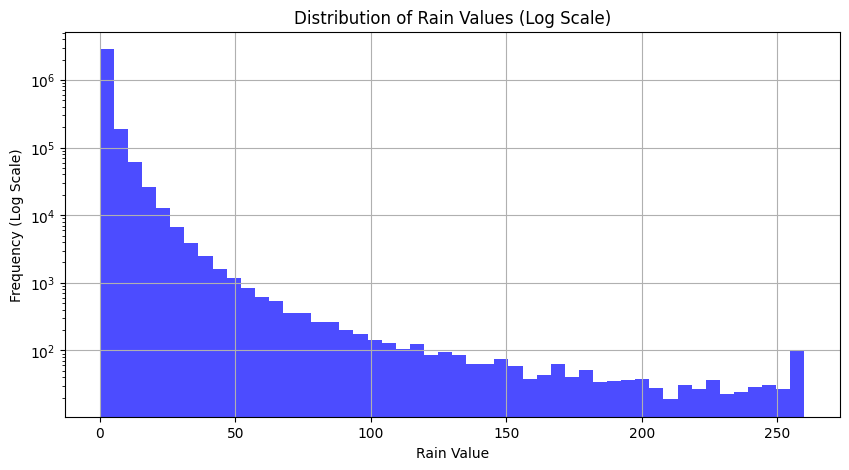

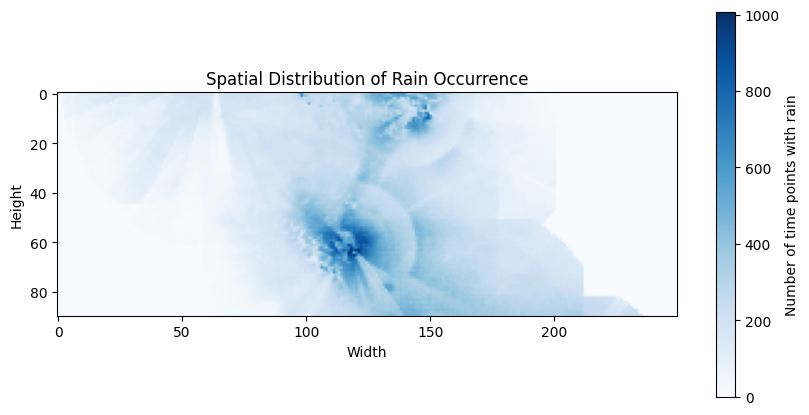

In [28]:
# Phân tích dữ liệu lượng mưa
total_pixels = 0
rain_pixels = 0
rain_values = []
spatial_rain_sum = np.zeros((90, 250))  # Tổng lượng mưa theo không gian

for dt in common_datetimes:
    radar_file = precip_files.get(dt)
    if radar_file:
        radar_data = read_geotiff(radar_file, data_type="Radar", verbose=True)
        if radar_data is not None:
            total_pixels += radar_data.size
            rain_pixels += np.sum(radar_data > 0)
            rain_values.extend(radar_data[radar_data > 0].flatten())
            spatial_rain_sum += (radar_data > 0).astype(np.float32)

rain_ratio = rain_pixels / total_pixels if total_pixels > 0 else 0
print(f"Percentage of pixels with rain: {rain_ratio * 100:.2f}%")
print(f"Percentage of pixels without rain: {(1 - rain_ratio) * 100:.2f}%")

if rain_values:
    print(f"Min rain value: {np.min(rain_values):.2f}")
    print(f"Max rain value: {np.max(rain_values):.2f}")
    print(f"Mean rain value (when rain > 0): {np.mean(rain_values):.2f}")
    print(f"Median rain value (when rain > 0): {np.median(rain_values):.2f}")

plt.figure(figsize=(10, 5))
plt.hist(rain_values, bins=50, log=True, color='blue', alpha=0.7)
plt.title("Distribution of Rain Values (Log Scale)")
plt.xlabel("Rain Value")
plt.ylabel("Frequency (Log Scale)")
plt.grid(True) 5
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(spatial_rain_sum, cmap='Blues')
plt.colorbar(label='Number of time points with rain')
plt.title("Spatial Distribution of Rain Occurrence")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

In [29]:
# Phân tích dữ liệu Himawari và ERA5
def analyze_features(files_dict, feature_list, data_type):
    for feature in feature_list:
        feature_values = []
        spatial_variance = np.zeros((HEIGHT, WIDTH))
        sample_count = 0
        for dt in common_datetimes:
            file_path = files_dict.get(dt, {}).get(feature)
            if file_path:
                data = read_geotiff(file_path, data_type=data_type, verbose=True)
                if data is not None:
                    feature_values.extend(data.flatten())
                    if sample_count == 0:
                        spatial_variance = data ** 2
                    else:
                        spatial_variance += data ** 2
                    sample_count += 1
        if feature_values:
            feature_values = np.array(feature_values)
            print(f"\nFeature: {feature} ({data_type})")
            print(f"Min value: {np.min(feature_values):.2f}")
            print(f"Max value: {np.max(feature_values):.2f}")
            print(f"Mean value: {np.mean(feature_values):.2f}")
            print(f"Std value: {np.std(feature_values):.2f}")

# Phân tích Himawari features
analyze_features(hima_files, HIMA_BANDS, "Himawari")

# Phân tích ERA5 features
analyze_features(era5_files, ERA5_PARAMS, "ERA5")


Feature: B09B (Himawari)
Min value: 121.52
Max value: 263.91
Mean value: 244.48
Std value: 11.04

Feature: B10B (Himawari)
Min value: 120.76
Max value: 269.40
Mean value: 252.04
Std value: 12.84

Feature: B11B (Himawari)
Min value: 124.97
Max value: 308.23
Mean value: 275.44
Std value: 19.84

Feature: B12B (Himawari)
Min value: 120.71
Max value: 278.52
Mean value: 258.04
Std value: 12.97

Feature: B14B (Himawari)
Min value: 83.92
Max value: 311.47
Mean value: 276.10
Std value: 21.40

Feature: B16B (Himawari)
Min value: 123.64
Max value: 282.43
Mean value: 261.41
Std value: 16.76

Feature: I2B (Himawari)
Min value: 125.54
Max value: 305.07
Mean value: 272.96
Std value: 20.72

Feature: I4B (Himawari)
Min value: 49.00
Max value: 319.83
Mean value: 285.40
Std value: 17.02

Feature: IRB (Himawari)
Min value: 126.05
Max value: 313.18
Mean value: 277.40
Std value: 20.84

Feature: WVB (Himawari)
Min value: 102.00
Max value: 254.90
Mean value: 235.23
Std value: 9.57

Feature: CAPE (ERA5)
Min v